# Final Project

Financial Data Science II

Fall 2021

Group Members:
* Junichi Koganemaru
* Bohang Wei
* Kaiyue Liao
* Peiwen Xiang
* Renjia Guo

Note: some tables are much easier to read in the Jupyter notebook than the exported pdf. These include the tables generated from the dataframes and from the package tabulate.

## Guidelines

You should submit both your `.ipynb` file and a `.pdf` version of the notebook via Canvas.

We should be able to take your code, and easily run it. It can load standard Python packages, of course, but it should otherwise be self-contained, not reliant upon any other code.

This is to be completed in your groups. All group members should participate in, and understand, all aspects of the analysis.

**Different groups are not allowed to interact or in any way communicate regarding their analyses.**

We are not looking for a formal "report," but **explain what you are doing** and **state any conclusions in practical terms.** For example, do not just say "The p-value is 0.02." What does that mean in practical terms?

Visualizations will be graded, in part, on their readability. Make fonts sufficiently large. Do not label axes with things such as "CSCORE_B." Use readable names.

You can email me with questions. If it is relevant to the entire class, I will ask you to post it on the Discussion Board. Please do not post questions directly to the Discussion Board regarding this, however.

## The Data

We will continue using the Fannie Mae data set used in the Homeworks 2 and 3. Here we will use a different subset. Just as in Homework 2, it only contains loans for which there is a current unpaid balance, i.e. for which `CURRENT_UPB` is greater than zero.

This data file is available as `project.csv` on Canvas.

## Your Objective

Imagine that you are constructing a simulation model that will generate realistic-looking loans of the type shown in this data set. We will focus here on one particular aspect of this: Simulating credit scores.

Our focus will be on the column `CSCORE_B`.



## Specific Steps

1. There are four missing values in `CSCORE_B`. Fill them in by using the following procedure: Cluster the loans, and then determine which cluster each of the loans with the missing value belong to. Replace the missing credit score value with the average credit score of those observations in the same cluster. Of course, the procedure cannot use `CSCORE_B` as one of the variables used to cluster loans. You can use any clustering procedure of your choice.
2. Visualize the distribution of `CSCORE_B`. Comment on its shape.
3. Find a parametric model that fits to the distribution of `CSCORE_B`. You can consider any distribution you would like, as long as it is parametric. Justify your choice using visualization and AIC. As in any real-world problem, you should not expect the fit to be "perfect." Get the best-fitting parametric distribution that you can. Report the MLE of the parameters for this fit.
4. Visualize how the distribution of `CSCORE_B` varies over different property types, i.e., for different values of `PROP`. Does it seem that the distribution changes across the different values of `PROP`? (Just to be clear, when I say "the distribution changes" I mean any aspect of the distribution changes. For example, going from a Normal(10,2) distribution to a Normal(12,2) is a "change" in distribution.)
5. Is there strong evidence that the distribution of `CSCORE_B` varies across the different values of `PROP`? Test a relevant hypothesis, and report the p-value. This test should be performed using a likelihood ratio test.

## Grading

Each of the five steps listed above will be assessed and scored based on three elements: (1) Appropriate choice of method(s) of analysis and/or visualization, (2) correct implmentation of those method(s), and (3) valid interpretation of the results. Each of these three elements will be given equal weight, and the total points allocated to each step are as follows: Step 1, 18 points. Step 2, 6 points. Step 3, 15 points. Step 4, 6 points. Step 5, 18 points. This is a total of 63 points.

In addition, the notebooks will be assessed based on the overall quality of the visualizations (on a scale of 0 to 6 points) on the overall quality of practical explanations of results (on a scale of 0 to 6 points), and on overall organization of the notebook, i.e., can we find where the different steps are, etc., or is it a mess (on a scale of 0 to 5 points).

Hence, there are total of 80 points.

## Peer Assessment

This is everyone's least favorite part, but I have little choice but to incoporate some component of peer feedback, i.e. assessing how much your groupmates contributed to the work. Without this, I have little basis for avoiding problems where students let the work fall on their groupmates.

Any negative information found through this process will be investigated by the instructor.

I do reserve the right to adjust individual students' grades based on lack of engagement with the project.

The easy way to avoid any problems is to make sure that everyone is engaged and participating. Please advise me of any issues as soon as possible.

# Step 1: Filling in missing credit scores

## Importing packages 

In [143]:
#Importing standard packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [358]:
%%capture
#Installing nonstandard packages 
import sys
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install gowers
!{sys.executable} -m pip install tabulate

## Exploratory Data Analysis

### Loading data

We first load in the data from project.csv.

In [3]:
#Loading data
loandata = pd.read_csv('project.csv', sep = '|')

loandata.columns = ("POOL_ID", "LOAN_ID", "ACT_PERIOD", "CHANNEL", "SELLER", "SERVICER",
                        "MASTER_SERVICER", "ORIG_RATE", "CURR_RATE", "ORIG_UPB", "ISSUANCE_UPB",
                        "CURRENT_UPB", "ORIG_TERM", "ORIG_DATE", "FIRST_PAY", "LOAN_AGE",
                        "REM_MONTHS", "ADJ_REM_MONTHS", "MATR_DT", "OLTV", "OCLTV",
                        "NUM_BO", "DTI", "CSCORE_B", "CSCORE_C", "FIRST_FLAG", "PURPOSE",
                        "PROP", "NO_UNITS", "OCC_STAT", "STATE", "MSA", "ZIP", "MI_PCT",
                        "PRODUCT", "PPMT_FLG", "IO", "FIRST_PAY_IO", "MNTHS_TO_AMTZ_IO",
                        "DLQ_STATUS", "PMT_HISTORY", "MOD_FLAG", "MI_CANCEL_FLAG", "Zero_Bal_Code",
                        "ZB_DTE", "LAST_UPB", "RPRCH_DTE", "CURR_SCHD_PRNCPL", "TOT_SCHD_PRNCPL",
                        "UNSCHD_PRNCPL_CURR", "LAST_PAID_INSTALLMENT_DATE", "FORECLOSURE_DATE",
                        "DISPOSITION_DATE", "FORECLOSURE_COSTS", "PROPERTY_PRESERVATION_AND_REPAIR_COSTS",
                        "ASSET_RECOVERY_COSTS", "MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS",
                        "ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY", "NET_SALES_PROCEEDS",
                        "CREDIT_ENHANCEMENT_PROCEEDS", "REPURCHASES_MAKE_WHOLE_PROCEEDS",
                        "OTHER_FORECLOSURE_PROCEEDS", "NON_INTEREST_BEARING_UPB", "PRINCIPAL_FORGIVENESS_AMOUNT",
                        "ORIGINAL_LIST_START_DATE", "ORIGINAL_LIST_PRICE", "CURRENT_LIST_START_DATE",
                        "CURRENT_LIST_PRICE", "ISSUE_SCOREB", "ISSUE_SCOREC", "CURR_SCOREB",
                        "CURR_SCOREC", "MI_TYPE", "SERV_IND", "CURRENT_PERIOD_MODIFICATION_LOSS_AMOUNT",
                        "CUMULATIVE_MODIFICATION_LOSS_AMOUNT", "CURRENT_PERIOD_CREDIT_EVENT_NET_GAIN_OR_LOSS",
                        "CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS", "HOMEREADY_PROGRAM_INDICATOR",
                        "FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT", "RELOCATION_MORTGAGE_INDICATOR",
                        "ZERO_BALANCE_CODE_CHANGE_DATE", "LOAN_HOLDBACK_INDICATOR", "LOAN_HOLDBACK_EFFECTIVE_DATE",
                        "DELINQUENT_ACCRUED_INTEREST", "PROPERTY_INSPECTION_WAIVER_INDICATOR",
                        "HIGH_BALANCE_LOAN_INDICATOR", "ARM_5_YR_INDICATOR", "ARM_PRODUCT_TYPE",
                        "MONTHS_UNTIL_FIRST_PAYMENT_RESET", "MONTHS_BETWEEN_SUBSEQUENT_PAYMENT_RESET",
                        "INTEREST_RATE_CHANGE_DATE", "PAYMENT_CHANGE_DATE", "ARM_INDEX",
                        "ARM_CAP_STRUCTURE", "INITIAL_INTEREST_RATE_CAP", "PERIODIC_INTEREST_RATE_CAP",
                        "LIFETIME_INTEREST_RATE_CAP", "MARGIN", "BALLOON_INDICATOR",
                        "PLAN_NUMBER", "FORBEARANCE_INDICATOR", "HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR",
                        "DEAL_NAME", "RE_PROCS_FLAG", "ADR_TYPE", "ADR_COUNT", "ADR_UPB")


Then we take at the dimensions of the data and examine the first first rows.

In [4]:
#Examining shape of data
loandata.shape

(4999, 108)

In [5]:
loandata.head()

,POOL_ID,LOAN_ID,ACT_PERIOD,CHANNEL,SELLER,SERVICER,MASTER_SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,...,MARGIN,BALLOON_INDICATOR,PLAN_NUMBER,FORBEARANCE_INDICATOR,HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR,DEAL_NAME,RE_PROCS_FLAG,ADR_TYPE,ADR_COUNT,ADR_UPB
0,1443,33229873,82021,R,Other,Other,FANNIE MAE,3.875,3.875,105000.0,...,NaN,N,NaN,7,N,CAS 2016 C03 G2,NaN,7,NaN,NaN
1,1473,40837377,82021,C,Other,"Pingora Loan Servicing, LLC",FANNIE MAE,4.625,4.625,238000.0,...,NaN,N,NaN,7,N,CAS 2017 C03 G1,NaN,7,NaN,NaN
2,1474,41378070,82021,C,Truist Bank (formerly SunTrust Bank),Truist Bank (formerly SunTrust Bank),FANNIE MAE,3.750,3.750,409000.0,...,NaN,N,NaN,7,N,CAS 2017 C04 G2,NaN,7,NaN,NaN
3,5228,125559711,82021,R,Other,Other,FANNIE MAE,3.090,3.090,314000.0,...,NaN,N,NaN,7,N,CAS 2021 R01 G1,NaN,7,NaN,NaN
4,5124,94867529,82021,R,Other,Other,FANNIE MAE,4.250,4.250,232000.0,...,NaN,N,NaN,7,N,CAS 2020 R01 G1,NaN,7,NaN,NaN


Next we convert some of the columns to the appropriate datatypes. 

In [6]:
#converting variables to appropraite datatype 
loandata['POOL_ID'] = loandata['POOL_ID'].astype("category")
loandata['LOAN_ID'] = loandata['LOAN_ID'].astype("category")
loandata['ZIP'] = loandata['ZIP'].astype("category")
loandata['ACT_PERIOD'] = loandata['ACT_PERIOD'].astype("datetime64[ns]")
loandata['ORIG_DATE'] = loandata['ORIG_DATE'].astype("datetime64[ns]")
loandata['FIRST_PAY'] = loandata['FIRST_PAY'].astype("datetime64[ns]")
loandata['MATR_DT'] = loandata['MATR_DT'].astype("datetime64[ns]")
loandata['FIRST_PAY_IO'] = loandata['FIRST_PAY_IO'].astype("datetime64[ns]")
loandata['Zero_Bal_Code'] = loandata['Zero_Bal_Code'].astype("category")
loandata['ZB_DTE'] = loandata['ZB_DTE'].astype("datetime64[ns]")
loandata['RPRCH_DTE'] = loandata['RPRCH_DTE'].astype("datetime64[ns]")
loandata['LAST_PAID_INSTALLMENT_DATE'] = loandata['LAST_PAID_INSTALLMENT_DATE'].astype("datetime64[ns]")
loandata['FORECLOSURE_DATE'] = loandata['FORECLOSURE_DATE'].astype("datetime64[ns]")
loandata['DISPOSITION_DATE'] = loandata['DISPOSITION_DATE'].astype("datetime64[ns]")
loandata['ORIGINAL_LIST_START_DATE'] = loandata['ORIGINAL_LIST_START_DATE'].astype("datetime64[ns]")
loandata['CURRENT_LIST_START_DATE'] = loandata['CURRENT_LIST_START_DATE'].astype("datetime64[ns]")
loandata['ZERO_BALANCE_CODE_CHANGE_DATE'] = loandata['ZERO_BALANCE_CODE_CHANGE_DATE'].astype("datetime64[ns]")
loandata['LOAN_HOLDBACK_EFFECTIVE_DATE'] = loandata['LOAN_HOLDBACK_EFFECTIVE_DATE'].astype("datetime64[ns]")
loandata['INTEREST_RATE_CHANGE_DATE'] = loandata['INTEREST_RATE_CHANGE_DATE'].astype("datetime64[ns]")
loandata['PAYMENT_CHANGE_DATE'] = loandata['PAYMENT_CHANGE_DATE'].astype("datetime64[ns]")

### Handling missing values

Since there are missing values in the dataset, we first seek to identify the columns with all missing values or "significantly many" missing values. We decided that any column containing more than 66/4999 missing values qualifies as having "significantly many" missing values.

In [7]:
#Identifying columns with all missing values or mostly missing values
na_columns = []
for vals in loandata.columns:
    if (loandata[vals].isna().all()) or (loandata[vals].isna().sum() > 66):
        na_columns.append(vals)

We were able to identify 61/108 of such columns.

In [8]:
len(na_columns)

61

We then proceed to drop these columns from the original dataset. We also drop columns where there is only 1 unique value.

In [9]:
#Dropping identified columns
X = loandata.drop(columns = na_columns)

#Dropping columns with 1 unique value
nunique = X.nunique()
cols_to_drop = nunique[nunique == 1].index
X = X.drop(cols_to_drop, axis=1)

In [10]:
loandata.shape

(4999, 108)

In total, so far we've dropped 68/108 columns.

In [11]:
X.shape

(4999, 40)

These are the remaining columns.

In [12]:
#remaining columns 
X.columns 

Index(['POOL_ID', 'LOAN_ID', 'CHANNEL', 'SELLER', 'SERVICER', 'ORIG_RATE',
       'CURR_RATE', 'ORIG_UPB', 'ISSUANCE_UPB', 'CURRENT_UPB', 'ORIG_TERM',
       'ORIG_DATE', 'FIRST_PAY', 'LOAN_AGE', 'REM_MONTHS', 'ADJ_REM_MONTHS',
       'MATR_DT', 'OLTV', 'OCLTV', 'NUM_BO', 'CSCORE_B', 'FIRST_FLAG',
       'PURPOSE', 'PROP', 'NO_UNITS', 'OCC_STAT', 'STATE', 'MSA', 'ZIP',
       'DLQ_STATUS', 'PMT_HISTORY', 'MOD_FLAG', 'ISSUE_SCOREB', 'SERV_IND',
       'CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS',
       'RELOCATION_MORTGAGE_INDICATOR', 'HIGH_BALANCE_LOAN_INDICATOR',
       'FORBEARANCE_INDICATOR', 'DEAL_NAME', 'ADR_TYPE'],
      dtype='object')

Next, we seek to identify the datapoints where the Borrower Credit Score at Origination is missing.

In [13]:
missing = X[ X['CSCORE_B'].isnull() == True ]

We've identified 4 rows (as expected) with missing credit scores. 

In [14]:
missing.head()

,POOL_ID,LOAN_ID,CHANNEL,SELLER,SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,ISSUANCE_UPB,CURRENT_UPB,...,PMT_HISTORY,MOD_FLAG,ISSUE_SCOREB,SERV_IND,CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS,RELOCATION_MORTGAGE_INDICATOR,HIGH_BALANCE_LOAN_INDICATOR,FORBEARANCE_INDICATOR,DEAL_NAME,ADR_TYPE
1772,5123,94259369,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",3.750,3.750,69000.0,36772.61,20602.03,...,000000000000000000000000000000000000000000000000,N,638.0,N,0.0,N,N,7,CAS 2019-HRP1,7
1933,1398,26909202,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",4.625,4.625,180000.0,176231.93,152852.86,...,000000000000000000000000000000000000000000000000,N,781.0,N,0.0,N,N,7,CAS 2015 C01 G2,7
3529,1484,43103805,R,Other,Other,3.625,3.625,120000.0,119070.60,108745.27,...,000000000000000000000000000000000000000000000000,N,806.0,N,0.0,N,N,7,CAS 2017 C05 G1,7
4759,5123,94576786,R,Other,Other,4.000,4.000,149000.0,73153.42,52627.71,...,000000000000000000000000000000000000000000000000,N,NaN,N,0.0,N,N,7,CAS 2019-HRP1,7


We realized that these 4 rows might have other missing values, so we decided to identify the other columns that might contain missing values.

In [15]:
missing_columns = []
for vals in missing.columns:
    if (missing[vals].isna().any()):
        missing_columns.append(vals)

We found that in addition to the Borrower Credit Score at Origination, the Number of Borrowers and the Borrower Credit Score At Issuance are also missing in some of the rows.

In [16]:
missing_columns

['NUM_BO', 'CSCORE_B', 'ISSUE_SCOREB']

Next we took a look at the correlation between these two new columns and the column containing the the Borrower Credit Score at Origination. We found that both columns have positive correlation and one column has high correlation, so instead of dropping the two columns we decided to fill in the missing values with appropriate values instead.

We found that in the original dataset, the column containing the number of borrowers only contains 1 missing value and the column containing the Borrower Credit Score At Issuance has 57 missing values.

We decided to only fill in the values in the 4 rows that we identified above, and then drop any row that contains missing values in the end.

For the column containing the number of borrowers, we decided to fill in the missing number of borrowers with -1. 
For the column containing the Borrower Credit Score At Issuance, we decided to fill in the missing value with the average of the column in the original dataset.

This could introduce some bias when we cluster later, but since we're only modifying 2/40 columns, and 2/4901 rows (after dropping 98/4999 rows), we don't think this will result in anything too significant.

In [19]:
print("Correlation between Borrower Credit Score at Origination and Number of Borrowers: " + str(X['CSCORE_B'].corr(X['NUM_BO'])))
print("Correlation between Borrower Credit Score at Origination and Borrower Credit Score at Issuance: " + str(X['CSCORE_B'].corr(X['ISSUE_SCOREB'])))

Correlation between Borrower Credit Score at Origination and Number of Borrowers: 0.0823690995560387
Correlation between Borrower Credit Score at Origination and Borrower Credit Score at Issuance: 0.6943425775597027


In [20]:
print("Number of missing values in the column with number of borrowers: " + str(X['NUM_BO'].isnull().sum()))
print("Number of missing values in the column with Borrower Credit Score at Issuance: " + str(X['ISSUE_SCOREB'].isnull().sum()))

Number of missing values in the column with number of borrowers: 1
Number of missing values in the column with Borrower Credit Score at Issuance: 57


count    4998.000000
mean        1.478191
std         0.522291
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: NUM_BO, dtype: float64


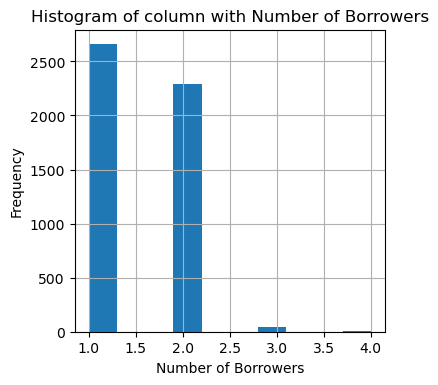

In [37]:
plt.figure(figsize=(4, 4), dpi=100)
X['NUM_BO'].hist()
plt.xlabel("Number of Borrowers")
plt.ylabel("Frequency")
plt.title('Histogram of column with Number of Borrowers')

print(X['NUM_BO'].describe())

count    4942.000000
mean      752.033590
std        53.856117
min       450.000000
25%       721.000000
50%       768.000000
75%       794.000000
max       818.000000
Name: ISSUE_SCOREB, dtype: float64


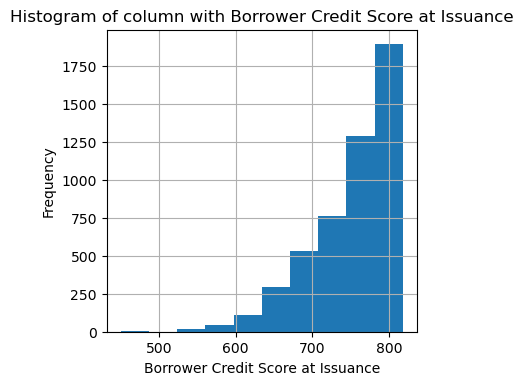

In [38]:
plt.figure(figsize=(4, 4), dpi=100)
X['ISSUE_SCOREB'].hist()
plt.xlabel("Borrower Credit Score at Issuance")
plt.ylabel("Frequency")
plt.title('Histogram of column with Borrower Credit Score at Issuance')

print(X['ISSUE_SCOREB'].describe())

In [39]:
#Filling in missing number of borrowers with -1
X['NUM_BO'] = X['NUM_BO'].fillna(-1)

#Filling in missing Borrower Credit Score at Issuance with the mean of the entire column
mean = X['ISSUE_SCOREB'].mean()
X.loc[X['LOAN_ID'] == 94576786, 'ISSUE_SCOREB'] = X.loc[X['LOAN_ID'] == 94576786, 'ISSUE_SCOREB'].fillna(mean)

After filling in the missing values, we double check to see if this was done correctly.

In [77]:
missing2 = X[ X['LOAN_ID'].isin([94259369,26909202, 43103805, 94576786]) ]

In [78]:
missing2['NUM_BO']

1772    2.0
1933    2.0
3529    2.0
4759   -1.0
Name: NUM_BO, dtype: float64

In [79]:
missing2['ISSUE_SCOREB']

1772    638.00000
1933    781.00000
3529    806.00000
4759    752.03359
Name: ISSUE_SCOREB, dtype: float64

Next we drop a few more ID columns, and also any row (other than the 4 rows that we identified above) that contains missing values.

In [40]:
X = X.drop(columns = ['POOL_ID', 'ZIP', 'ORIG_DATE'])
X = X.dropna(subset = X.columns.difference(['CSCORE_B']), how = 'any')

In total, we've dropped 71/108 columns and also 98/4999 rows. 

In [14]:
X.shape

(4901, 37)

Next we store the filtered data without the Loan ID associated to each loan and also the Borrower Credit Score at Origination. This is the dataset that we will be performing clustering on.

In [41]:
CreditScoreB = X['CSCORE_B']
X_withoutID = X.drop(columns = ['LOAN_ID', 'CSCORE_B'])

In [146]:
X_withoutID.head()

,CHANNEL,SELLER,SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,ISSUANCE_UPB,CURRENT_UPB,ORIG_TERM,FIRST_PAY,...,PMT_HISTORY,MOD_FLAG,ISSUE_SCOREB,SERV_IND,CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS,RELOCATION_MORTGAGE_INDICATOR,HIGH_BALANCE_LOAN_INDICATOR,FORBEARANCE_INDICATOR,DEAL_NAME,ADR_TYPE
0,R,Other,Other,3.875,3.875,105000.0,103725.97,91736.60,360,1970-01-01 00:00:00.000052015,...,000000000000000000000000000000000000000000000000,N,807.0,N,0.0,N,N,7,CAS 2016 C03 G2,7
1,C,Other,"Pingora Loan Servicing, LLC",4.625,4.625,238000.0,234629.13,211659.69,360,1970-01-01 00:00:00.000082016,...,000000000000000000000000000000000000000000000000,N,618.0,N,0.0,N,N,7,CAS 2017 C03 G1,7
2,C,Truist Bank (formerly SunTrust Bank),Truist Bank (formerly SunTrust Bank),3.750,3.750,409000.0,406027.37,370177.64,360,1970-01-01 00:00:00.000122016,...,000000000000000000000000000000000000000000000000,N,776.0,N,0.0,N,N,7,CAS 2017 C04 G2,7
3,R,Other,Other,3.090,3.090,314000.0,309175.28,309175.28,360,1970-01-01 00:00:00.000122020,...,XXXXXXXXXXXXXXXXXXXXXXXXXXXX00000000000000000000,N,817.0,N,0.0,N,N,7,CAS 2021 R01 G1,7
4,R,Other,Other,4.250,4.250,232000.0,230000.00,223310.96,360,1970-01-01 00:00:00.000072019,...,000000000000000000000000000000000000000000000000,N,805.0,N,0.0,N,N,7,CAS 2020 R01 G1,7


In [147]:
X_withoutID.shape

(4901, 35)

### Data Visualization

Before performing clustering, we perform nonlinear dimension reduction with UMAP and TSNE w.r.t. to the Gower's metric.

In [42]:
import gower

We use the gowers package to calculate the distance matrix w.r.t to the Gower's dissimilarity metric. 

In [43]:
#Calculating distance matrix w.r.t. Gowers dissimilarity metric
dist_matrix = gower.gower_matrix(X_withoutID)

In [149]:
dist_matrix.shape

(4901, 4901)

In [48]:
#Using tSNE and UMAP for nonlinear dimension reduction
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [345]:
%%capture
X_tsne = TSNE(n_components=2, metric = 'precomputed').fit_transform(dist_matrix)
X_umap = umap.UMAP(metric = 'precomputed').fit_transform(dist_matrix)

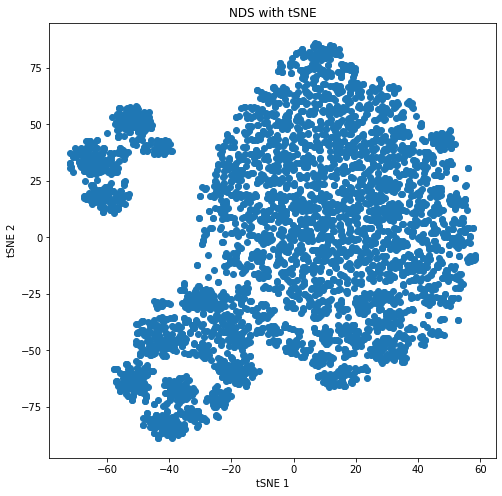

In [341]:
plt.figure(figsize=(8,8))
plt.scatter(X_tsne [:,0],X_tsne [:,1])
plt.title("NDS with tSNE")
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()

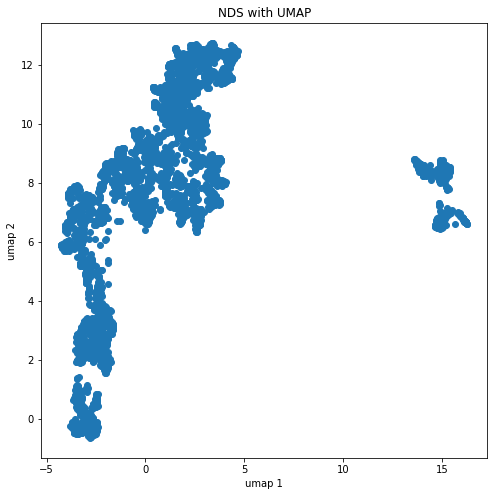

In [342]:
plt.figure(figsize=(8,8))
plt.scatter(X_umap[:,0],X_umap[:,1])
plt.title("NDS with UMAP")
plt.xlabel('umap 1')
plt.ylabel('umap 2')
plt.show()

## Clustering

We decided to go with a type of hierarchical clustering for our filtered dataset. We try to visualize the dataset with different number of clusers with UMAP and TSNE. 

In [53]:
#Clustering using AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

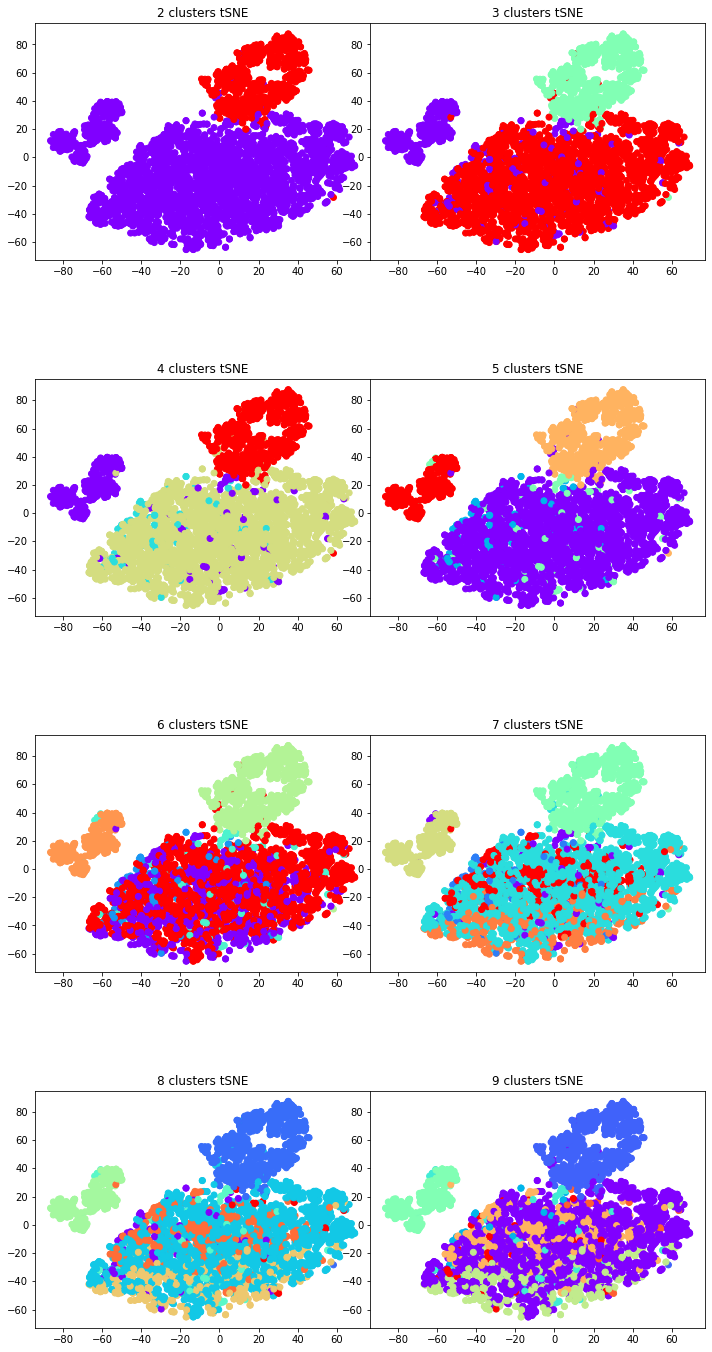

In [153]:
#Comibing plots with differet number of clusters, visualizing with tSNE
fig = plt.figure
fig, axs = plt.subplots(4,2, figsize=(12, 24))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for k in range(2,10):
    clustering_Agglomerative = AgglomerativeClustering(n_clusters = k, affinity= 'precomputed', linkage = 'complete').fit(dist_matrix)
    axs[k-2].scatter(X_tsne[:,0],X_tsne[:,1], c = clustering_Agglomerative.labels_, cmap='rainbow')
    axs[k-2].set_title(str(k)+' clusters tSNE')

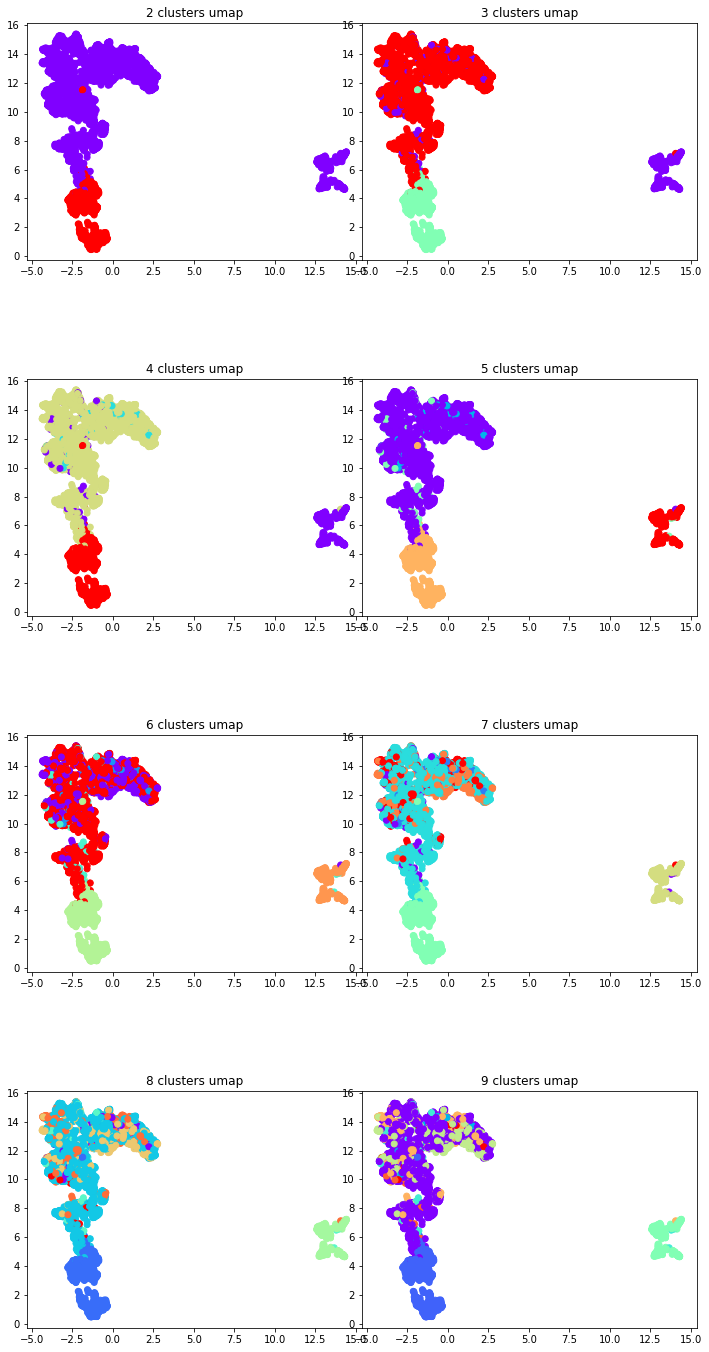

In [154]:
#Comibing plots with differet number of clusters, visualizing with UMAP
fig = plt.figure
fig, axs = plt.subplots(4,2, figsize=(12, 24))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for k in range(2,10):
    clustering_Agglomerative = AgglomerativeClustering(n_clusters = k, affinity= 'precomputed', linkage = 'complete').fit(dist_matrix)
    axs[k-2].scatter(X_umap[:,0],X_umap[:,1], c = clustering_Agglomerative.labels_, cmap='rainbow')
    axs[k-2].set_title(str(k)+' clusters umap')

Next we try to select a reasonable number of clusters to work with. To do so we first visualize the dendrogram constructed from the complete linkage function.

In [44]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

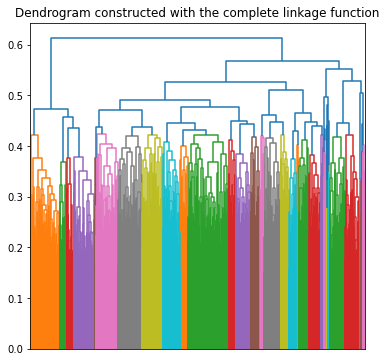

In [348]:
condensed_dist_matrix = squareform(dist_matrix)
Z = hierarchy.linkage(condensed_dist_matrix, 'complete')
plt.figure(figsize=(6,6))
plt.title("Dendrogram constructed with the complete linkage function")
dn = hierarchy.dendrogram(Z, no_labels = True)
plt.show()

The dendrogram seems to suggest that cutting somewhere between 0.5 and 0.6 would be a good choice. The result should be around 4 or 5 clusters. To cross validate this we also take a look at the Silhouette score of the clusters. 

In [65]:
from sklearn.metrics import silhouette_score

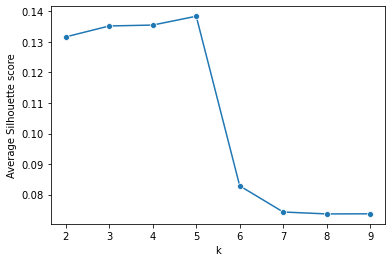

In [68]:
silhouette_scores = []

for k in range(2,10):
    clustering_Agglomerative = AgglomerativeClustering(n_clusters = k, affinity= 'precomputed', linkage = 'complete').fit(dist_matrix)
    silhouette_scores.append(silhouette_score(dist_matrix, clustering_Agglomerative.labels_, metric = 'precomputed'))
    
sns.lineplot(x = range(2,10), y = silhouette_scores, marker = 'o')
plt.xlabel('k')
plt.ylabel('Average Silhouette score')
plt.show()

Here we compare the average Silhouette scores of each cluster even though the clustering method we chose isn't centroid based. 

Based on both the dendrogram and the average Silhouette scores computed above, we decided on working with 5 clusters.

In [54]:
clustering = AgglomerativeClustering(n_clusters = 5, affinity= 'precomputed', linkage = 'complete').fit(dist_matrix)

Here we try to visualize the 5 clusters using tSNE and UMAP. 

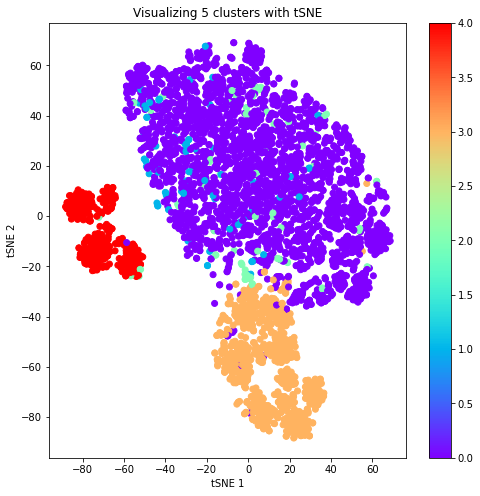

In [347]:
plt.figure(figsize=(8,8))
plt.scatter(X_tsne [:,0],X_tsne [:,1], c = clustering.labels_, cmap='rainbow')
plt.title("Visualizing 5 clusters with tSNE")
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.colorbar()
plt.show()

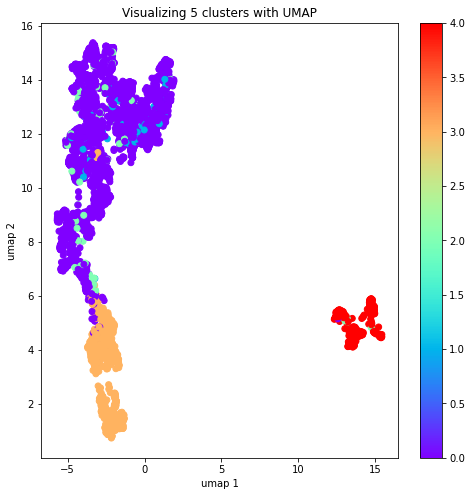

In [346]:
plt.figure(figsize=(8,8))
plt.scatter(X_umap [:,0],X_umap [:,1], c = clustering.labels_, cmap='rainbow')
plt.title("Visualizing 5 clusters with UMAP")
plt.xlabel('umap 1')
plt.ylabel('umap 2')
plt.colorbar()
plt.show()

## Replacing Credit Score value with Clustering results 

Next we proceed to replace the missing credit scores with the clustering results.

In [60]:
#Adding cluster labels in the filtered data frame  
X['ClusterId'] = pd.Series(clustering.labels_, X.index)

In [80]:
X.head()

,LOAN_ID,CHANNEL,SELLER,SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,ISSUANCE_UPB,CURRENT_UPB,ORIG_TERM,...,MOD_FLAG,ISSUE_SCOREB,SERV_IND,CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS,RELOCATION_MORTGAGE_INDICATOR,HIGH_BALANCE_LOAN_INDICATOR,FORBEARANCE_INDICATOR,DEAL_NAME,ADR_TYPE,ClusterId
0,33229873,R,Other,Other,3.875,3.875,105000.0,103725.97,91736.60,360,...,N,807.0,N,0.0,N,N,7,CAS 2016 C03 G2,7,0
1,40837377,C,Other,"Pingora Loan Servicing, LLC",4.625,4.625,238000.0,234629.13,211659.69,360,...,N,618.0,N,0.0,N,N,7,CAS 2017 C03 G1,7,0
2,41378070,C,Truist Bank (formerly SunTrust Bank),Truist Bank (formerly SunTrust Bank),3.750,3.750,409000.0,406027.37,370177.64,360,...,N,776.0,N,0.0,N,N,7,CAS 2017 C04 G2,7,0
3,125559711,R,Other,Other,3.090,3.090,314000.0,309175.28,309175.28,360,...,N,817.0,N,0.0,N,N,7,CAS 2021 R01 G1,7,4
4,94867529,R,Other,Other,4.250,4.250,232000.0,230000.00,223310.96,360,...,N,805.0,N,0.0,N,N,7,CAS 2020 R01 G1,7,0


In [106]:
X.shape

(4897, 38)

We isolate the rows with the missing credit scores and also split the original dataframe into 5 separate dataframes based on the clustering.

In [30]:
toreplace = X[ X['LOAN_ID'].isin([94259369,26909202, 43103805, 94576786]) ]

In [61]:
cluster0 = X[X['ClusterId'] == 0]
cluster1 = X[X['ClusterId'] == 1]
cluster2 = X[X['ClusterId'] == 2]
cluster3 = X[X['ClusterId'] == 3]
cluster4 = X[X['ClusterId'] == 4]

Here we take note of the sizes of each cluster. We see that the first cluster is significantly larger than the rest, and the next two clusters is significantly smaller than the rest. 

In [62]:
print(cluster0.shape)
print(cluster1.shape)
print(cluster2.shape)
print(cluster3.shape)
print(cluster4.shape)

(3344, 38)
(82, 38)
(75, 38)
(952, 38)
(448, 38)


We found that using our approach, the first and last loans were grouped into to the fourth cluster and the second and third loans were grouped into the first cluster.

In [89]:
toreplace

,LOAN_ID,CHANNEL,SELLER,SERVICER,ORIG_RATE,CURR_RATE,ORIG_UPB,ISSUANCE_UPB,CURRENT_UPB,ORIG_TERM,...,MOD_FLAG,ISSUE_SCOREB,SERV_IND,CUMULATIVE_CREDIT_EVENT_NET_GAIN_OR_LOSS,RELOCATION_MORTGAGE_INDICATOR,HIGH_BALANCE_LOAN_INDICATOR,FORBEARANCE_INDICATOR,DEAL_NAME,ADR_TYPE,ClusterId
1772,94259369,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",3.750,3.750,69000.0,36772.61,20602.03,180,...,N,638.00000,N,0.0,N,N,7,CAS 2019-HRP1,7,3
1933,26909202,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",4.625,4.625,180000.0,176231.93,152852.86,360,...,N,781.00000,N,0.0,N,N,7,CAS 2015 C01 G2,7,0
3529,43103805,R,Other,Other,3.625,3.625,120000.0,119070.60,108745.27,360,...,N,806.00000,N,0.0,N,N,7,CAS 2017 C05 G1,7,0
4759,94576786,R,Other,Other,4.000,4.000,149000.0,73153.42,52627.71,180,...,N,752.03359,N,0.0,N,N,7,CAS 2019-HRP1,7,3


We then calculated the average credit score of the clusters and then filled in the missing values, as instructed in the prompt.

In [63]:
mean0 = cluster0['CSCORE_B'].mean()
mean3 = cluster3['CSCORE_B'].mean()

X_filled = X 

X_filled.loc[X_filled['LOAN_ID'] == 94259369, 'CSCORE_B'] = X_filled.loc[X_filled['LOAN_ID'] == 94259369, 'CSCORE_B'].fillna(mean3)
X_filled.loc[X_filled['LOAN_ID'] == 26909202, 'CSCORE_B'] = X_filled.loc[X_filled['LOAN_ID'] == 26909202, 'CSCORE_B'].fillna(mean0)
X_filled.loc[X_filled['LOAN_ID'] == 43103805, 'CSCORE_B'] = X_filled.loc[X_filled['LOAN_ID'] == 43103805, 'CSCORE_B'].fillna(mean0)
X_filled.loc[X_filled['LOAN_ID'] == 94576786, 'CSCORE_B'] = X_filled.loc[X_filled['LOAN_ID'] == 94576786, 'CSCORE_B'].fillna(mean3)

In [197]:
print(mean0)
print(mean3)

754.0032914422502
757.2589473684211


We double check to see if we filled in the credit scores successfully.

In [97]:
X_filled['CSCORE_B'].isnull().any()

False

# Step 2: Visualizing the distribution of the Borrower Credit Score at Origination

## Visualizing the distribution using seaborn

After filling in the missing credit scores, we visualize the distribution of the credit scores with a histogram plot. We fit a nonparametric smooth with KDE to help with the visualization.

count    4901.000000
mean      755.288211
std        47.271554
min       493.000000
25%       725.000000
50%       766.000000
75%       794.000000
max       827.000000
Name: CSCORE_B, dtype: float64


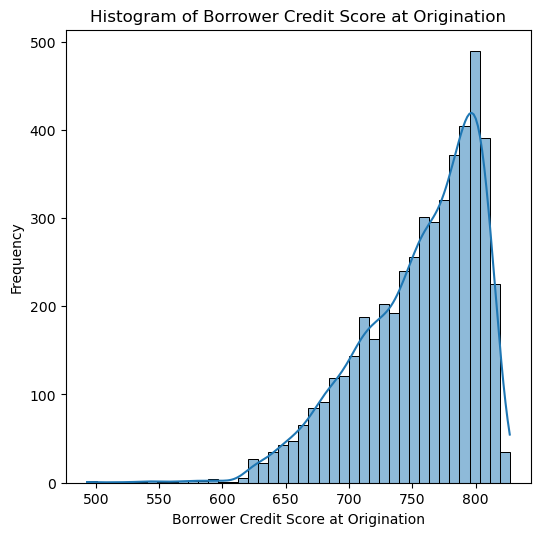

In [343]:
print(X_filled['CSCORE_B'].describe())
plt.figure(figsize = (6,6), dpi=100)
sns.histplot(data=X_filled['CSCORE_B'], stat = 'count', kde = True)
plt.title("Histogram of Borrower Credit Score at Origination")
plt.xlabel("Borrower Credit Score at Origination")
plt.ylabel("Frequency")
plt.show()

We notice that the distribution is left-skewed and the Borrower Credit Scores at Originiation are concentrated around 800.

# Step 3: Identifying a parametric model that fits the distribution of the Borrower Credit Score at Origination

## Visualizing the distributions of different parametric fits

In [136]:
import scipy.stats
from tabulate import tabulate

We use the .fit() function from scipy.stats to fit the credit score data to the distributions we've encountered in lectures. We then plot each fit against the original histogram. 

We note that in our implementation we normalized the histogram by setting density = True; this avoids rescaling each pdf from scipy.stats. 

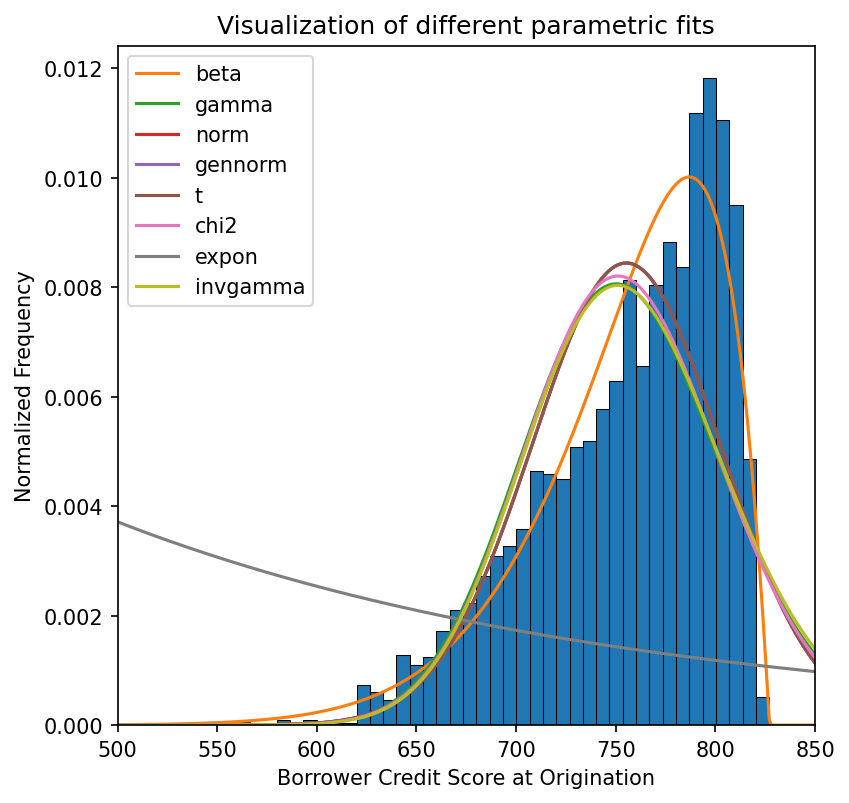

In [276]:
plt.figure(figsize=(6, 6), dpi=150)
N = len(X_filled['CSCORE_B'].values.flatten())
x = np.arange(N)
y = X_filled['CSCORE_B']
h = plt.hist(y.values.flatten(), bins=50, linewidth=0.5, edgecolor = 'black', density = True)

sample_distributions = ['beta', 'gamma', 'norm', 'gennorm', 't', 'chi2', 'expon', 'invgamma']
for distributions in sample_distributions:
    distribution = getattr(scipy.stats, distributions)
    parameters = distribution.fit(y)
    args = parameters[:-2]
    floc = parameters[-2]
    fscale = parameters[-1]
    if len(args) > 0:
        pdf = distribution.pdf(x, *args, loc=floc, scale=fscale) 
    else:
        pdf = distribution.pdf(x, loc=floc, scale=fscale) 
    
    plt.plot(pdf, label=distributions)
    plt.xlim(500,850)

plt.xlabel("Borrower Credit Score at Origination")
plt.ylabel("Normalized Frequency")
plt.title("Visualization of different parametric fits")
plt.legend( prop={"size":10})
plt.show()

## AIC value of each fit

From the visualization we notice that the parametric fits with the beta seems to capture the left-skewness of the original distribution the best, and the parametric fit with the exponential distribution fit the worst. We validate this by computing the AIC of each fitted parametric model.

In [279]:
AIC_results=[]

for distributions in sample_distributions:
    np.seterr(divide = 'ignore') 
    distribution = getattr(scipy.stats, distributions)
    parameters = distribution.fit(y)
    args = parameters[:-2]
    floc = parameters[-2]
    fscale = parameters[-1]
    if len(args) > 0:
        aic = -2*np.sum(distribution.logpdf(y, *args, loc = floc, scale = fscale)) + 2*(len(parameters))
        rs ={         "Distribution":distributions,
                      "distribution parameters":args,
                      "location":floc,
                      "scale":fscale,
                      "AIC": aic}
        AIC_results.append(rs)
    if len(args) == 0:
        aic = -2*np.sum(distribution.logpdf(y, loc = floc, scale = fscale)) + 2*(len(parameters))
        rs ={         "Distribution":distributions,
                      "distribution parameters":args,
                      "location":floc,
                      "scale":fscale,
                      "AIC": aic}
        AIC_results.append(rs)
    
AIC_df = pd.DataFrame(AIC_results).sort_values(by = ['AIC'])

In [278]:
#this table might be hard to read in the exported pdf, but in the Jupyter notebook the table looks quite nice
print(tabulate(AIC_df, headers='keys', tablefmt='psql', showindex=False))

+----------------+------------------------------------------+------------+--------------+---------+
| Distribution   | distribution parameters                  |   location |        scale |     AIC |
|----------------+------------------------------------------+------------+--------------+---------|
| beta           | (17.734212702067985, 2.0140878739300003) |   122.093  |    705.088   | 50265.1 |
| norm           | ()                                       |   755.288  |     47.2667  | 51707.1 |
| t              | (121721.78219990141,)                    |   755.289  |     47.2664  | 51709   |
| gennorm        | (2.0005800863015124,)                    |   755.283  |     66.8553  | 51709.1 |
| chi2           | (414.579797372979,)                      |    52.8342 |      1.69244 | 51945   |
| gamma          | (143.9960393295234,)                     |   158.692  |      4.13667 | 51997   |
| invgamma       | (375.59554551199284,)                    |  -210.105  | 361948       | 52060.9 |


We note that the fitted model using the beta distribution has the smallest AIC value amongst the 8 models, and the fitted model using the exponential distribution has the highest AIC value. This is consistent with what we observed above. 

Therefore based on the visualization and the AIC values, we decided to model the credit scores using the beta distribution. 

## MLE of the parameters 

The pdf of the  beta distribution is given by $$f(x ; \alpha, \beta, \mu, \sigma) = \frac{1}{\sigma} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}\left( \frac{x-\mu}{\sigma}\right)^{\alpha - 1}\left(1 - \frac{x- \mu}{\sigma} \right)^{\beta - 1}.$$

The MLE of the four parameters $$\hat{\theta}_{MLE} = (\hat{\alpha},\hat{\beta},\hat{\mu}, \hat{\sigma})$$ is given by 

$$\hat{\theta}_{MLE} = \underset{\theta = (\alpha,\beta,\mu,\sigma) \in \mathbb{R}^4}{\operatorname{argmax}}  L(\theta),$$

where $$L(\theta) = \prod_{i=1}^N f(X_i; \theta) = \prod_{i=1}^N f(X_i; \alpha, \beta, \mu, \sigma) .$$

In our setup, $N = 4901$, the number of credit scores we are considering. 

In general, there is no known closed form expression of the MLEs for the beta distribution for arbitrary shape parameters, so we approximate them numerically instead. Using the .fit() function from scipy.stats, we find that the MLE is approximated by the following.

In [281]:
parameters = scipy.stats.beta.fit(y)
alpha_MLE = parameters[0]
beta_MLE =parameters[1]
mu_MLE = parameters[2]
sigma_MLE = parameters[3]

print("MLE of alpha: " + str(alpha_MLE))
print("MLE of beta: " + str(beta_MLE))
print("MLE of mu: " + str(mu_MLE))
print("MLE of sigma: " + str(sigma_MLE))

MLE of alpha: 17.734212702067985
MLE of beta: 2.0140878739300003
MLE of mu: 122.09282878984381
MLE of sigma: 705.0881369452222


# Step 4: Visualizing the borrower credit score at origination over different property types

## Splitting the filtered dataframe by property type

In [250]:
X_filled['PROP'].value_counts()

SF    3277
PU    1079
CO     464
MH      52
CP      29
Name: PROP, dtype: int64

In [251]:
X_SF = X_filled[ X_filled['PROP'] == "SF"]
X_PU = X_filled[ X_filled['PROP'] == "PU"]
X_CO = X_filled[ X_filled['PROP'] == "CO"]      
X_MH = X_filled[ X_filled['PROP'] == "MH"]
X_CP = X_filled[ X_filled['PROP'] == "CP"]

In [253]:
df_dict = {
    "All": X_filled,
    "Single-family home": X_SF,
    "Planned Urban Development": X_PU, 
    "Condominium": X_CO,
    "Manufactured home": X_MH,
    "Co-operative": X_CP
}

## Fitting the splitted credit scores over property type using the beta distribution

In [298]:
beta_results=[]

for prop, df in df_dict.items():
        y = df['CSCORE_B']
        parameters = scipy.stats.beta.fit(y)
        alpha_MLE = parameters[0]
        beta_MLE = parameters[1]
        mu_MLE = parameters[2]
        sigma_MLE = parameters[3]
        rs ={         "Property Type": prop,
                      "Counts": len(df['CSCORE_B']),
                      "MLE for alpha": alpha_MLE,
                      "MLE for beta": beta_MLE,
                      "MLE for mu": mu_MLE,
                      "MLE for sigma": sigma_MLE
                      }
        beta_results.append(rs)

beta_df = pd.DataFrame(beta_results)

## Final results

+---------------------------+----------+-----------------+----------------+--------------+-----------------+
| Property Type             |   Counts |   MLE for alpha |   MLE for beta |   MLE for mu |   MLE for sigma |
|---------------------------+----------+-----------------+----------------+--------------+-----------------|
| All                       |     4901 |        17.7342  |       2.01409  |     122.093  |         705.088 |
| Single-family home        |     3277 |        13.8572  |       1.98798  |     237.643  |         589.604 |
| Planned Urban Development |     1079 |        24.5124  |       1.95576  |     -84.4683 |         910.772 |
| Condominium               |      464 |        18.7054  |       1.78287  |      97.9206 |         726.607 |
| Manufactured home         |       52 |         1.2604  |       0.76409  |     637.636  |         182.364 |
| Co-operative              |       29 |         4.57278 |       0.858519 |     617.289  |         184.711 |
+------------------

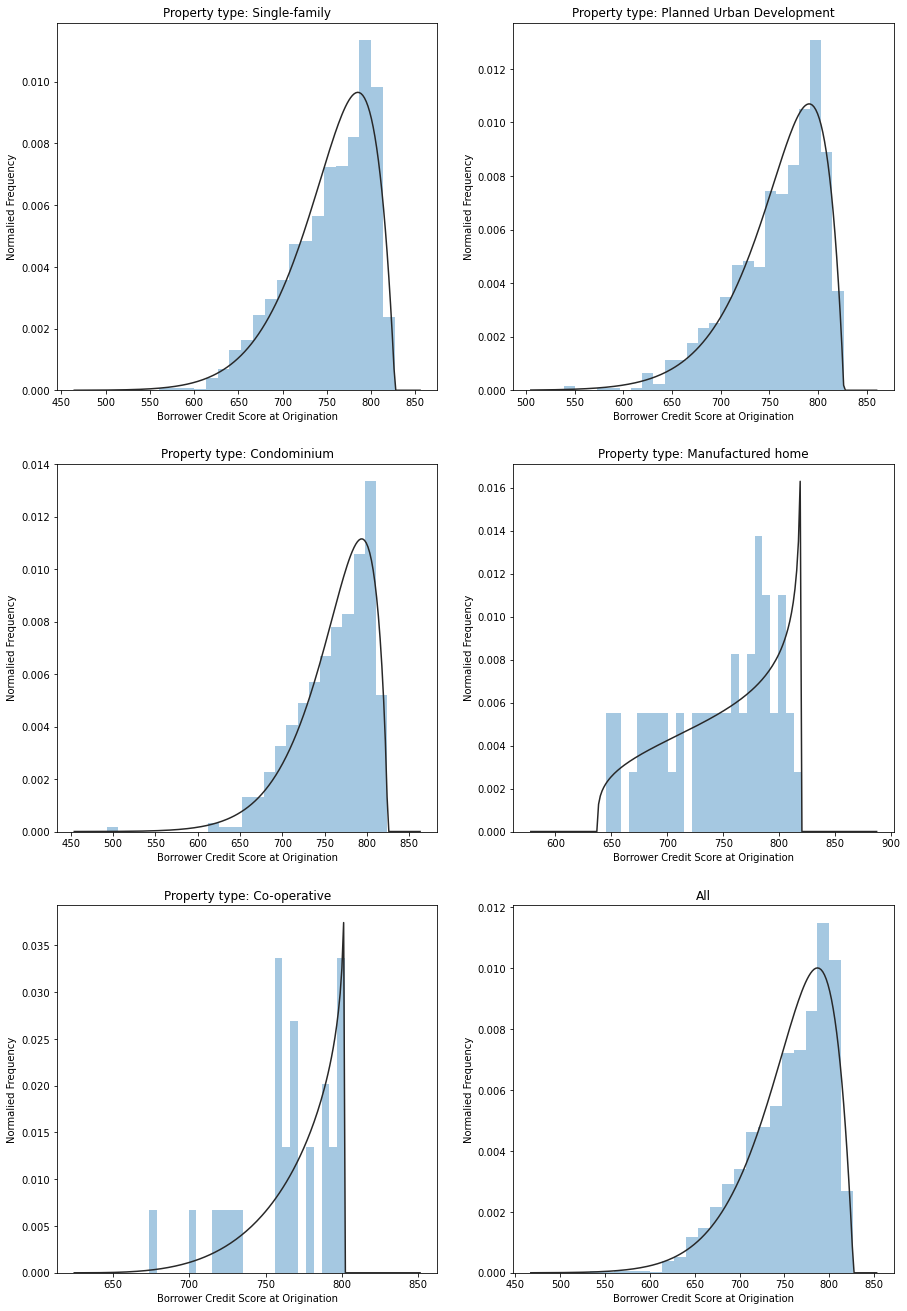

In [350]:
fig, axs = plt.subplots(3,2, figsize=(15, 23))

sns.distplot(X_SF ['CSCORE_B'], fit = scipy.stats.beta, bins = 25, kde = False, ax=axs[0,0])
sns.distplot(X_PU ['CSCORE_B'], fit = scipy.stats.beta, bins = 25, kde = False, ax=axs[0,1])
sns.distplot(X_CO ['CSCORE_B'], fit = scipy.stats.beta, bins = 25, kde = False, ax=axs[1,0])
sns.distplot(X_MH ['CSCORE_B'], fit = scipy.stats.beta, bins = 25, kde = False, ax=axs[1,1])
sns.distplot(X_CP ['CSCORE_B'], fit = scipy.stats.beta, bins = 25, kde = False, ax=axs[2,0])
sns.distplot(X_filled ['CSCORE_B'], fit = scipy.stats.beta, bins = 25, kde = False, ax=axs[2,1])

axs[0,0].set(xlabel = "Borrower Credit Score at Origination", ylabel = "Normalied Frequency", title = "Property type: Single-family")
axs[0,1].set(xlabel = "Borrower Credit Score at Origination", ylabel = "Normalied Frequency", title = "Property type: Planned Urban Development")
axs[1,0].set(xlabel = "Borrower Credit Score at Origination", ylabel = "Normalied Frequency", title = "Property type: Condominium")
axs[1,1].set(xlabel = "Borrower Credit Score at Origination", ylabel = "Normalied Frequency", title = "Property type: Manufactured home")
axs[2,0].set(xlabel = "Borrower Credit Score at Origination", ylabel = "Normalied Frequency", title = "Property type: Co-operative")
axs[2,1].set(xlabel = "Borrower Credit Score at Origination", ylabel = "Normalied Frequency", title = "All")
print(tabulate(beta_df, headers='keys', tablefmt='psql', showindex=False))
#this table might be hard to read in the exported pdf, but in the Jupyter notebook the table looks quite nice

Based on the visualization of the parametric fits and the MLE for the three parameters, it seems like the distribution changes across different property types. 

# Step 5: Hypothesis testing

## Mathematical setup

We model the boworrer's credit scores at origination by independent random variables $\{X_i\}_{i=1}^{4901}$ where the $X_i$'s are drawn from the beta distribution. If $X_i$ is drawn from the beta distribution, then we write $X_i \sim beta(\theta_i)$, where $\theta_i= (\alpha_i, \beta_i, \mu_i, \sigma_i)$. 

If the distribution of parameter scores does not change over the various property types, then the three parameters for the parametric fit should be constant. Therefore we propose the following test by partitioning the credit scores by the 5 different property types.

We again model the boworrer's credit scores at origination by independent random variables $\{X_i\}_{i=1}^{4901}$ where the $X_i$'s are drawn from the beta distribution, but we assume in addition that the parameter $\theta$ in $beta(\theta)$ is constant for credit scores of loans of the same property type. 

Recall that these are the MLE parameters found using the .fit() function over credit scores of various property types.

In [330]:
#this table might be hard to read in the exported pdf, but in the Jupyter notebook the table looks quite nice
print(tabulate(beta_df, headers='keys', tablefmt='psql', showindex=False))

+---------------------------+----------+-----------------+----------------+--------------+-----------------+
| Property Type             |   Counts |   MLE for alpha |   MLE for beta |   MLE for mu |   MLE for sigma |
|---------------------------+----------+-----------------+----------------+--------------+-----------------|
| All                       |     4901 |        17.7342  |       2.01409  |     122.093  |         705.088 |
| Single-family home        |     3277 |        13.8572  |       1.98798  |     237.643  |         589.604 |
| Planned Urban Development |     1079 |        24.5124  |       1.95576  |     -84.4683 |         910.772 |
| Condominium               |      464 |        18.7054  |       1.78287  |      97.9206 |         726.607 |
| Manufactured home         |       52 |         1.2604  |       0.76409  |     637.636  |         182.364 |
| Co-operative              |       29 |         4.57278 |       0.858519 |     617.289  |         184.711 |
+------------------

We define $\Theta_0 = \{ \theta  = (\alpha_1, \alpha_2, \alpha_3, \alpha_4, \alpha_5, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5,\mu_1, \mu_2, \mu_3, \mu_4, \mu_5, \sigma_1, \sigma_2,\sigma_3, \sigma_4, \sigma_5) \in \mathbb{R}^{20} \mid \alpha_1 = \alpha_2 = \alpha_3 =  \alpha_4 = \alpha_5, \beta_1 =\beta_2 =\beta_3 =\beta_4 =\beta_5, \mu_1 = \mu_2= \mu_3= \mu_4=\mu_5, \sigma_1 = \sigma_2 =\sigma_3 =  \sigma_4 = \sigma_5\}$ and we wish to test $$H_0 : \theta \in \Theta_0 \quad \text{versus} \quad H_1 : \theta \in \mathbb{R}^{20} \setminus \Theta_0.$$

The likelihood function $L(\theta)$ is given by $$ L(\theta) = \prod_{i=1}^{4901} f(X_i, \theta_i).$$

We use the likelihood ratio test by constructing the test statistic $$T = -2 \log \left( \frac{\max_{\theta \in \Theta_0} L(\theta)}{\max_{\theta \in \Theta_0^c} L(\theta)} \right).$$

We note that under $H_0$, we're assuming that all the independent random variables are drawn from the beta distribution with the same parameter $\theta$. Therefore $\underset{\theta \in \Theta_0}{\operatorname{argmax}}  L(\theta) = \hat{\theta}_{MLE}$ where 

In [331]:
%%latex 
\begin{multline}
\mathbb{R}^{20} \ni \hat{\theta}_{MLE} \approx (17.7342,17.7342,17.7342,17.7342,17.7342,2.01409,2.01409,2.01409,2.01409,2.01409, \\ 122.093,122.093,122.093,122.093,122.093,705.088,705.088,705.088,705.088,705.088)
\end{multline}

<IPython.core.display.Latex object>

Here the MLE parameters are apporximated by using .fit() on all the data points. 

Since we freeze the other parameters as constants when we compute the MLEs, we next note that under our additional hypothesis that the parameter $\theta$ in $beta(\theta)$ is constant for credit scores of loans of the same property type, we find that $\underset{\theta \in \Theta_0^c}{\operatorname{argmax}} L(\theta) = \hat{\theta}_{MLE, 5}$, where

In [332]:
%%latex 
\begin{multline}
\mathbb{R}^{20} \ni  \hat{\theta}_{MLE, 5} \approx (13.8572,  24.5124, 18.7054, 1.2604, 4.57278,1.98798, 1.95576,   1.78287, 0.76409, 0.858519, \\ 237.643, -84.4683, 97.9206,  637.636, 617.289, 589.604, 910.772, 726.607, 182.364,  184.711)
\end{multline}

<IPython.core.display.Latex object>

Here the MLE parameters are estimated by using .fit() on the data points partitioned by the different property types. 

Furthermore, we note that since $\dim(\Theta_0) = 4$ (this is easy to see as $\Theta_0$ can naturally be written as the nullspace of a rank 4 matrix), by Wilk's theorem we have $T \sim \chi^2_{20-4} = \chi^2_{16}$ under $H_0$ for sufficiently large $N$.

The p-value for this test is then $\mathbb{P}(\chi^2_{16} > T)$. 

## Implementation

Next we implemenet the test by calculating $T$ for our observed data and the p-value for this test.

In [297]:
from scipy.stats import chi2

We calculate $T$ via  

$$T = -2 \log \left( \frac{L(\hat{\theta}_{MLE})}{L(\hat{\theta}_{MLE,5})} \right) = -2 \left( \log L(\hat{\theta}_{MLE}) - \log L(\hat{\theta}_{MLE,5}) \right)$$

where $$\log L(\theta) = \sum_{i=1}^{4901} \log f(x ;\theta).$$

In [339]:
alpha, b, mu, sigma = scipy.stats.beta.fit(X_filled['CSCORE_B']) 

alpha_1, b_1, mu_1, sigma_1 = scipy.stats.beta.fit(X_SF['CSCORE_B'])
alpha_2, b_2, mu_2, sigma_2 = scipy.stats.beta.fit(X_PU['CSCORE_B']) 
alpha_3, b_3, mu_3, sigma_3 = scipy.stats.beta.fit(X_CO['CSCORE_B']) 
alpha_4, b_4, mu_4, sigma_4 = scipy.stats.beta.fit(X_MH['CSCORE_B']) 
alpha_5, b_5, mu_5, sigma_5 = scipy.stats.beta.fit(X_CP['CSCORE_B']) 


logL_H0 = np.sum(scipy.stats.beta.logpdf(X_filled['CSCORE_B'], alpha, b,  loc = mu, scale = sigma))

logL_H1 = np.sum(scipy.stats.beta.logpdf(X_SF['CSCORE_B'], alpha_1, b_1, loc = mu_1, scale = sigma_1)) + \
          np.sum(scipy.stats.beta.logpdf(X_PU['CSCORE_B'], alpha_2, b_2, loc = mu_2, scale = sigma_2)) + \
          np.sum(scipy.stats.beta.logpdf(X_CO['CSCORE_B'], alpha_3, b_3, loc = mu_3, scale = sigma_3)) + \
          np.sum(scipy.stats.beta.logpdf(X_MH['CSCORE_B'], alpha_4, b_4, loc = mu_4, scale = sigma_4)) + \
          np.sum(scipy.stats.beta.logpdf(X_CP['CSCORE_B'], alpha_5, b_5, loc = mu_5, scale = sigma_5))

T = -2* (logL_H0 - logL_H1)
print("T = " + str(T))

T = 72.75724408860697


Using $T$, we can calulate $p = \mathbb{P}(\chi^2_{16} > T)$ as follows.

In [340]:
p = 1 - chi2.cdf(T,16)
print("p = " + str(p))

p = 3.2660627535818776e-09


Since $p \ll 0.01$, practically this means that there is very strong evidence against the null hypothesis $H_0$, that the distribution stays constant across the various property types. This coincides with our intuition from part 4 that the distribution seems to vary across different property types.

# References

1. Visualizing distributions of data. https://seaborn.pydata.org/tutorial/distributions.html
2. Fitting empirical distribution to theoretical ones with Scipy (Python)? https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
3. scipy.stats.beta. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
4. Lecture notes  by Professor Schafer.
5. All of Statistics by Wasserman. 
